QOSF Sceening Task 2 solution - Vedant Dwivedi 

Imports

In [1]:
import pennylane as qml

from pennylane import numpy as np
from pennylane.templates.embeddings import AmplitudeEmbedding, AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.optimize import NesterovMomentumOptimizer , GradientDescentOptimizer, AdamOptimizer
from pennylane.init import strong_ent_layers_uniform
import torch
from torch.autograd import Variable
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from itertools import chain
import matplotlib.pyplot as plt

Data import, preprocessing and splitting

In [2]:
# load the training dataset
data_train=np.loadtxt('/Users/apple/variational_classifer/data/mock_train_set.csv', delimiter=',', skiprows=1)

In [3]:
# load the testing dataset
data_test=np.loadtxt('/Users/apple/variational_classifer/data/mock_test_set.csv', delimiter=',', skiprows=1)

In [4]:
# uses the column 4  as the target and use the data from column0 to column3 
X_test = data_test[:, 0:4]
y_test = data_test[:,4]

In [5]:
X = data_train[:, 0:4]
y = data_train[:,4]

In [6]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[3] ** 2)/ np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [7]:
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

First X sample (original)  : [2789.26 1000.     10.     20.  ]
First X sample (padded)    : [2.78926e+03 1.00000e+03 1.00000e+01 2.00000e+01 3.00000e-01 0.00000e+00]
First X sample (normalized): [9.41304384e-01 3.37474593e-01 3.37474593e-03 6.74949187e-03
 1.01242378e-04 0.00000000e+00]
First features sample      : [ 0.01509247 -1.1071487   1.1071487  -0.34424302  0.34424302]


In [8]:
feature_size= features.shape[1]
batch_size = 10
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 6
num_data = len(y)
num_train = int(0.75 * num_data)

In [9]:
#split into train and validation
np.random.seed(0)
index = np.random.permutation(range(num_data))


X_train = features[index[:num_train]]
y_train = y[index[:num_train]]
X_val = features[index[num_train:]]
y_val = y[index[num_train:]]

Building the quantum classifier

In [10]:
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.PauliX(wires=0)

In [11]:
# quantum device handle
dev = qml.device("default.qubit", wires=num_qubits)

In [12]:
def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])
    if num_qubits >= 2:
     # Apply additional CNOT to entangle the last with the first qubit
        qml.CNOT(wires=[num_qubits - 1, 0])

In [13]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [14]:
@qml.qnode(dev)
def circuit(weights, x):
    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

In [15]:
def cost(weights, bias, features, expectations):
    e_predicted = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(expectations,e_predicted)

def square_loss(expectations, e_predicted):
    loss = 0
    for l, p in zip(expectations, e_predicted):
        loss = loss + (l - p) ** 2

    loss = loss / len(expectations)
    return loss

In [16]:
def accuracy(expectations, e_predicted):

    loss = 0
    for l, p in zip(expectations, e_predicted):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(expectations)

    return loss

Training and Inference

In [17]:
#draw random quantum node weights----------
#weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
#bias_init = np.array(0.0, requires_grad=True)

In [18]:
weights_init = strong_ent_layers_uniform(num_layers, num_qubits, seed=42)
bias_init = 0.0
weights = weights_init
bias = bias_init

/var/folders/ct/dqdky4352zx_f2qfwpf8xq840000gn/T/ipykernel_16648/4063326688.py:1: UserWarning: The init module will be deprecated soon, since templates can now provide a method that returns the shape of parameter tensors.
  weights_init = strong_ent_layers_uniform(num_layers, num_qubits, seed=42)


In [19]:
#build the optimizer object-------------------
#opt = AdamOptimizer(0.1, beta1=0.9, beta2=0.999)
#opt = NesterovMomentumOptimizer(0.5)
opt = GradientDescentOptimizer()

In [20]:
lossplot = []
train_acc, train_val_acc, test_acc = [], [], []
for it in range(60):

    #Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)
    
    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in X_train]
    predictions_val =  [np.sign(variational_classifier(weights, bias, f)) for f in X_val]
    predictions_test =  [np.sign(variational_classifier(weights, bias, f)) for f in X_test]


    # Compute accuracy on train and validation set
    acc_train = accuracy(y_train, predictions_train)
    acc_val = accuracy(y_val, predictions_val)
    acc_test = accuracy(y_test, predictions_test)

    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} | Acc test: {:0.7f}"
        "".format(it + 1, cost(weights, bias, features, y_train), acc_train, acc_val, acc_test))
    lossplot.append(cost(weights, bias, features, y_train))
    train_acc.append(acc_train)
    train_val_acc.append(acc_val)
    test_acc.append(acc_test)

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.1476544 | Acc train: 0.0000000 | Acc validation: 0.0000000 | Acc test: 0.1833333
Iter:     2 | Cost: 1.0785985 | Acc train: 0.0000000 | Acc validation: 0.0000000 | Acc test: 0.2000000
Iter:     3 | Cost: 1.0554011 | Acc train: 0.0000000 | Acc validation: 0.0000000 | Acc test: 0.2083333
Iter:     4 | Cost: 0.9990567 | Acc train: 0.0000000 | Acc validation: 0.0000000 | Acc test: 0.2250000
Iter:     5 | Cost: 0.9516326 | Acc train: 0.0000000 | Acc validation: 0.0000000 | Acc test: 0.2250000
Iter:     6 | Cost: 0.9169037 | Acc train: 0.0000000 | Acc validation: 0.0000000 | Acc test: 0.2250000
Iter:     7 | Cost: 0.8704324 | Acc train: 0.0044444 | Acc validation: 0.0000000 | Acc test: 0.2333333
Iter:     8 | Cost: 0.8018633 | Acc train: 0.0044444 | Acc validation: 0.0000000 | Acc test: 0.2666667
Iter:     9 | Cost: 0.7648991 | Acc train: 0.0044444 | Acc validation: 0.0000000 | Acc test: 0.2916667
Iter:    10 | Cost: 0.7343841 | Acc train: 0.0044444 | Acc validation: 0.

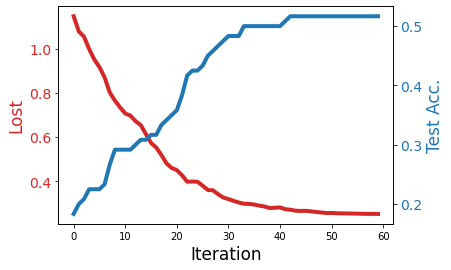

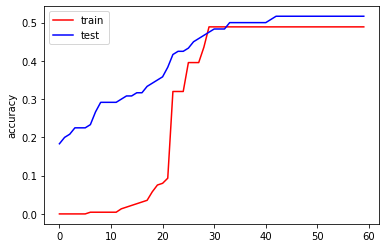

In [21]:
fig, ax1 = plt.subplots()
iters = np.arange(0, 60, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Lost", fontsize=17, color=colors[0])
ax1.plot(iters, lossplot, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)

plt.show()

plt.plot(train_acc,'r',label="train")
plt.plot(test_acc,'b',label="test")
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [22]:
print(metrics.confusion_matrix(y_test,predictions_test))

[[ 0 58]
 [ 0 62]]
